In [173]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/inflation-rate/inflation_rate.csv
/kaggle/input/list-of-exchange-2014/list_of_exchange.csv
/kaggle/input/days-off-2014-russia-2/days_off.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv


In [174]:
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif

In [175]:
import warnings
warnings.filterwarnings("ignore")

# Useful functions

In [176]:
def get_boxplot(column):
    
    # plot boxplots for numerical features
    
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x='default', y=column,
                data=data,
                ax=ax, showmeans=True)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
def vis_importance(xcol, ycol):
    
    # plot histograms for categorical features to visualize
    # dependence on target variable
    # xcol - feature to explore, ycol - target variable
    
    pd.crosstab(data[xcol], data[ycol]).plot(kind='bar')
    plt.title('Default frequency for {}'.format(xcol))
    plt.xlabel(xcol)
    plt.ylabel('Frequency of default')
    plt.show()
    
def outliers_detection(data, col):
    
    # detect outliers in data[col]
    
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5 * IQR
    right = perc75 + 1.5 * IQR
    print('min: {0}, max: {1}'.format(data[col].min(), data[col].max()))
    print('outlier boundaries: [{0}, {1}]'.format(left, right))
    if len(data[~data[col].between(left, right)]) > 0:
        print('ratio of outliers: {}'.format(len(data[(~data[col].between(left, right))&(~data[col].isna())])/len(data)))

def drop_outliers(data, col):
    
    # detect outliers in data[col]
    
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    return data[(data[col].between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR))|(data[col].isna())]

# Data loading

In [177]:
data = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [ ]:
test.info()

In [ ]:
data.info()

In [178]:
data.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

# EDA & Data Preprocessing

In [179]:
# convert to datetime
data.app_date = pd.to_datetime(data.app_date)
test.app_date = pd.to_datetime(test.app_date)

In [58]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,days_passed,app_date_month,app_date_of_week,exchange_trend
0,25905,2014-02-01,SCH,M,4.127134,Y,Y,0,0,-2.008753,...,2,9.798127,4,1,N,0,2368,2,5,1.042724
1,63161,2014-03-12,SCH,F,4.077537,N,N,0,0,-1.532276,...,3,9.852194,4,1,N,0,2329,3,2,1.018685
2,25887,2014-02-01,SCH,M,3.218876,Y,N,2,0,-1.408142,...,2,10.308953,1,4,Y,0,2368,2,5,1.042724
3,16222,2014-01-23,SCH,F,3.970292,N,N,0,0,-2.057471,...,3,9.210340,1,3,N,0,2377,1,3,1.030754
4,101655,2014-04-18,GRD,M,3.871201,N,N,0,1,-1.244723,...,3,10.308953,1,4,Y,0,2292,4,4,0.995901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04,GRD,F,3.806662,N,N,0,0,-1.792064,...,2,9.740969,4,4,N,0,2337,3,1,1.024668
73795,76821,2014-03-24,SCH,M,3.713572,Y,Y,0,0,-2.058029,...,2,11.156251,1,4,N,0,2317,3,0,0.995822
73796,103695,2014-04-22,SCH,M,3.433987,N,N,0,0,-1.512635,...,3,10.714418,2,2,N,0,2288,4,1,1.002876
73797,861,2014-01-04,SCH,F,3.367296,N,N,0,1,-1.479334,...,3,9.472705,2,3,N,1,2396,1,5,0.994834


In [ ]:
test

In [180]:
# fill nan with the most frequent class
val_counts = data['education'].value_counts()
max_value = val_counts.max()
data['education'].fillna(val_counts[val_counts == max_value].index[0],
                         inplace=True)

val_counts = test['education'].value_counts()
max_value = val_counts.max()
test['education'].fillna(val_counts[val_counts == max_value].index[0],
                         inplace=True)

In [ ]:
data.shape, test.shape

In [186]:
# feature engeneering
today = pd.to_datetime('27JULY2020')
data['days_passed'] = (today - data.app_date).dt.days
data['app_date_month'] = data['app_date'].dt.month
data['app_date_day'] = data['app_date'].dt.day
data['app_date_interval'] = data['app_date_day'].apply(lambda x: 1 if 8 < x < 22 else 0)
data['app_date_of_week'] = data['app_date'].dt.dayofweek

test['days_passed'] = (today - test.app_date).dt.days
test['app_date_month'] = test['app_date'].dt.month
test['app_date_day'] = test['app_date'].dt.day
test['app_date_interval'] = test['app_date_day'].apply(lambda x: 1 if 8 < x < 22 else 0)
test['app_date_of_week'] = test['app_date'].dt.dayofweek

In [187]:
data.shape, test.shape

((73799, 24), (36349, 23))

In [ ]:
data['app_date'].max()

In [ ]:
data['app_date'].min()

У нас есть дата подачи заявки. Попробую в качестве гипотезы оценить влияния курса рубля на невозврат долга. Беру курс на момент подачи заявки. В необработанном виде такой фактор лучше не использовать. Через определенный промежуток времени значения признака выйдут за рамки попавших в обучающую выборку данных и будут неверно интерпретированы моделью. Чтобы избежать негативных последствий, преобразуем курс рубля в отношении текущего курса(на момент рассмотрения заявки) к медианному значению за предыдущие 27 дней. Теперь признак характеризует не абсолютное значение курса рубля, а тенденцию(рост, падение, стабильное состояние) в рассматриваемый период

In [188]:
list_of_exchange_trends = pd.read_csv('../input/list-of-exchange-2014/list_of_exchange.csv', sep=';')
list_of_exchange_trends.app_date = pd.to_datetime(list_of_exchange_trends.app_date)
list_of_exchange_trends = list_of_exchange_trends.dropna()

In [ ]:
list_of_exchange_trends.info()

In [ ]:
list_of_exchange_trends

In [ ]:
data

In [189]:
data = data.merge(list_of_exchange_trends, how='left', left_on='app_date', right_on='app_date')
test = test.merge(list_of_exchange_trends, how='left', left_on='app_date', right_on='app_date')

Попробую еще добавить к признакам уровень индекс инфляции по месяцам

In [190]:
inflation_rate = pd.read_csv('../input/inflation-rate/inflation_rate.csv', sep=';')
inflation_rate

,app_date_month,inflation_rate
0,1,6.05
1,2,6.20
2,3,6.92
3,4,7.33


In [191]:
data = data.merge(inflation_rate, how='left', left_on='app_date_month', right_on='app_date_month')
test = test.merge(inflation_rate, how='left', left_on='app_date_month', right_on='app_date_month')

Посмотрим, влияет ли как-то тот факт, что заявка была подана в выходной или праздничный день, на возврат кредитов?

In [192]:
days_off = pd.read_csv('../input/days-off-2014-russia-2/days_off.csv', sep=';')
days_off.app_date = pd.to_datetime(days_off.app_date)
days_off

,app_date,day_off
0,2014-04-30,0
1,2014-04-29,0
2,2014-04-28,0
3,2014-04-27,1
4,2014-04-26,1
...,...,...
115,2014-01-05,1
116,2014-01-04,1
117,2014-01-03,1
118,2014-01-02,1


In [193]:
data = data.merge(days_off, how='left', left_on='app_date', right_on='app_date')
test = test.merge(days_off, how='left', left_on='app_date', right_on='app_date')

In [194]:
data.shape, test.shape

((73799, 27), (36349, 26))

In [195]:
data.isnull().sum()

client_id            0
app_date             0
education            0
sex                  0
age                  0
car                  0
car_type             0
decline_app_cnt      0
good_work            0
score_bki            0
bki_request_cnt      0
region_rating        0
home_address         0
work_address         0
income               0
sna                  0
first_time           0
foreign_passport     0
default              0
days_passed          0
app_date_month       0
app_date_day         0
app_date_interval    0
app_date_of_week     0
exchange_trend       0
inflation_rate       0
day_off              0
dtype: int64

In [196]:
test.isnull().sum()

client_id            0
app_date             0
education            0
sex                  0
age                  0
car                  0
car_type             0
decline_app_cnt      0
good_work            0
score_bki            0
bki_request_cnt      0
region_rating        0
home_address         0
work_address         0
income               0
sna                  0
first_time           0
foreign_passport     0
days_passed          0
app_date_month       0
app_date_day         0
app_date_interval    0
app_date_of_week     0
exchange_trend       0
inflation_rate       0
day_off              0
dtype: int64

In [197]:
data.sample(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,foreign_passport,default,days_passed,app_date_month,app_date_day,app_date_interval,app_date_of_week,exchange_trend,inflation_rate,day_off
4896,83511,2014-03-31,GRD,M,30,N,N,0,0,-1.369871,...,N,1,2310,3,31,0,0,0.981477,6.92,0
42945,40140,2014-02-16,SCH,F,25,N,N,0,0,-1.552441,...,N,0,2353,2,16,1,6,1.014598,6.20,1


In [198]:
# columns by types
num_col = ['days_passed', 'age', 'decline_app_cnt', 'score_bki',
          'region_rating', 'income', 'exchange_trend', 'inflation_rate']
cat_col = ['app_date_month', 'app_date_day', 'app_date_of_week', 'education', 'home_address', 'work_address', 'sna',
          'first_time']
bin_col = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'day_off', 'app_date_interval']

## Default - target variable

Text(0.5, 1.0, 'Histogram for default')

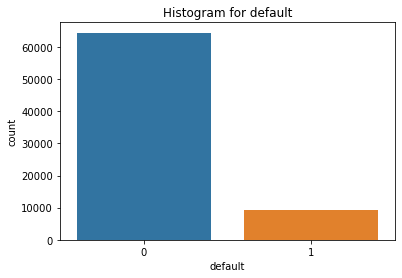

In [199]:
sns.countplot(data.default)
plt.title('Histogram for default')

Выборка является несбалансированной: "дефолтные" клиенты составляют всего около 12%. Я попробовал поизменять данные методами over-\undersampling, также использовал алгоритм SMOTE, вот [здесь](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/) хорошо об этом написано. Однако, это никак не улучшило результат модели, поэтому оставляю выборку несбалансированной.

В сети есть множество постов и ресурсов, которые учат нас бороться с несбалансированностью классов (class imbalance) в задаче классификации. Обычно они предлагают методы сэмплирования: искусственно дублировать наблюдения из редкого класса, или выкинуть часть наблюдений из популярного класса. Этим постом я хочу прояснить, что «проклятие» дисбаланса классов – это миф, важный лишь для отдельных типов задач. [Статья на Хабре.](https://habr.com/ru/post/349078/)



## Distribution of numerical features

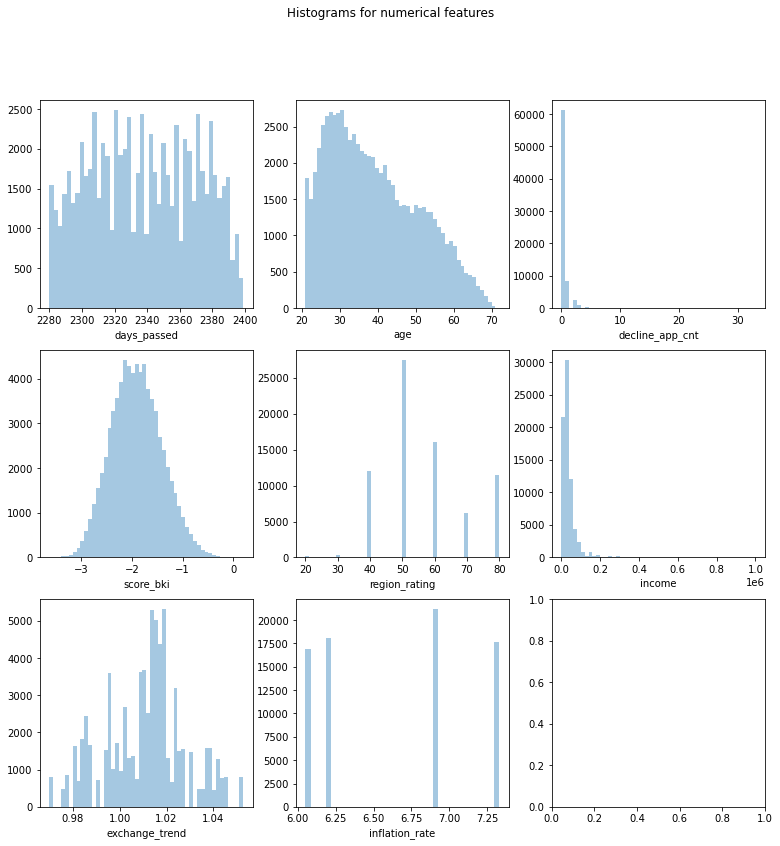

In [201]:
fig, axes = plt.subplots(3, 3, figsize=(13,13))
for col, i in zip(num_col, range(9)):
    sns.distplot(data[col], kde=False, ax=axes.flat[i])
fig.suptitle('Histograms for numerical features');

С помощью логарифмирования приведу распределение признаков 'age', 'income' к более "нормальному" виду.

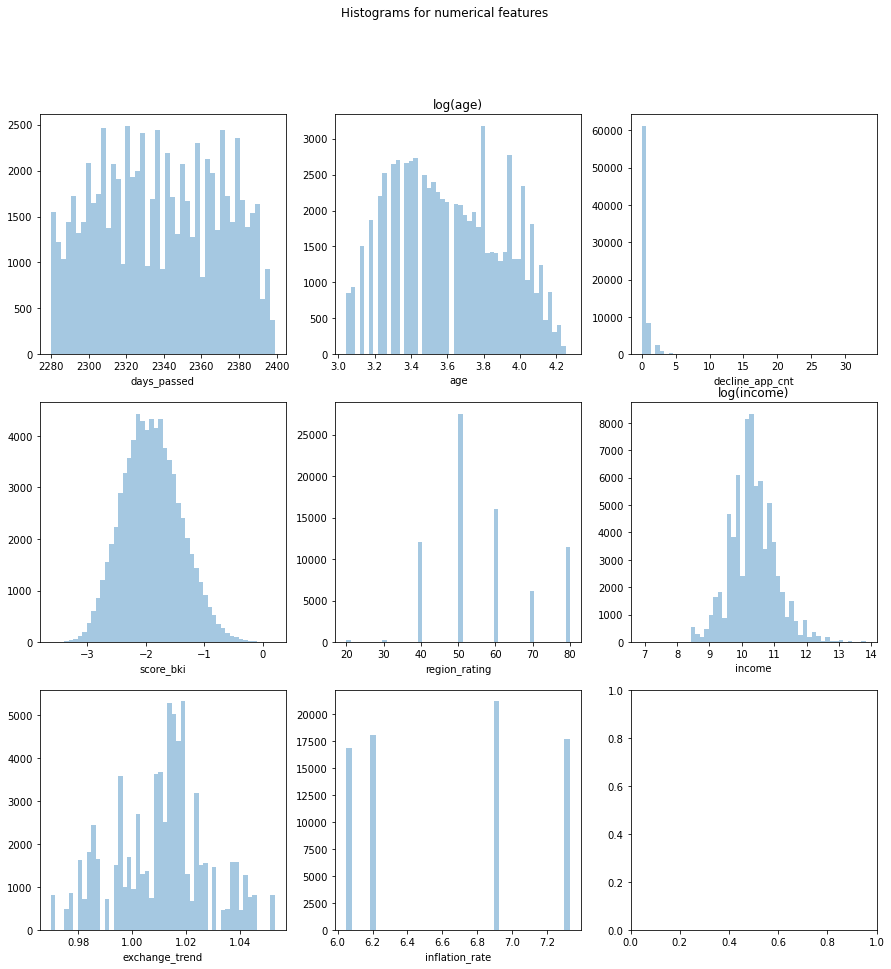

In [202]:
# normalization using log func
col_to_log = ['age', 'income']
fig, axes = plt.subplots(3, 3, figsize=(15,15))
for col, i in zip(num_col, range(9)):
    if col in col_to_log:
        sns.distplot(data[col][data[col]>0].apply(lambda w: np.log(w)),
                     kde=False, ax=axes.flat[i])
    else: sns.distplot(data[col], kde=False, ax=axes.flat[i])
axes[0][1].set_title('log(age)')
axes[1][2].set_title('log(income)')
fig.suptitle('Histograms for numerical features');

In [203]:
data[col_to_log] = data[col_to_log].apply(lambda w: np.log(w))
test[col_to_log] = test[col_to_log].apply(lambda w: np.log(w))

## Correlation matrix

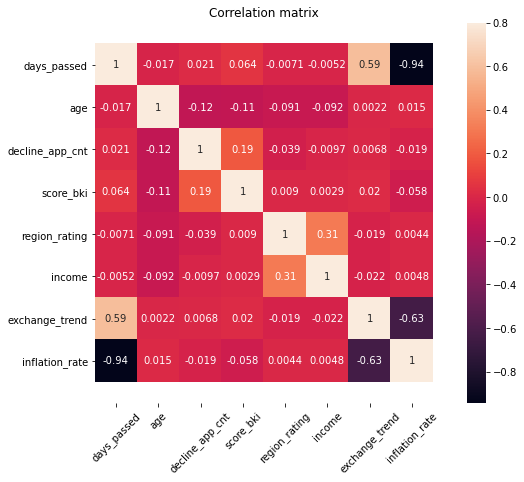

In [204]:
corrmat = data[num_col].corr()
f, ax = plt.subplots(figsize=(12, 7))
chart = sns.heatmap(corrmat, vmax=.8, square=True, annot=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
bottom, top = chart.get_ylim()
plt.title('Correlation matrix')
ax.set_ylim(bottom + 0.5, top - 0.5);

Есть сильная обратная корреляция между уровнем инфляции и между тем, сколько времени прошло с момента когда подавали заявку на кредит и между индексом инфляции и ростом кура валют есть инфляция. Интересно.

## Features' significance

### Visual assessment of categorical variables

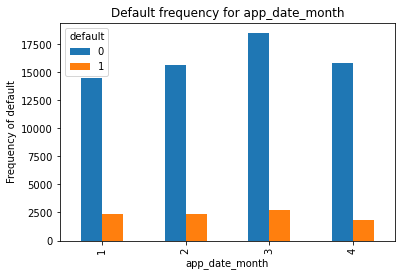

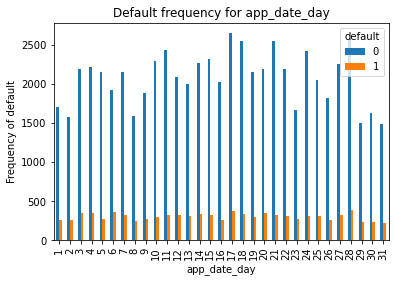

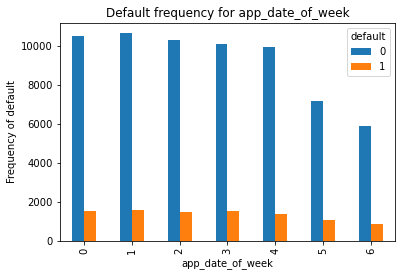

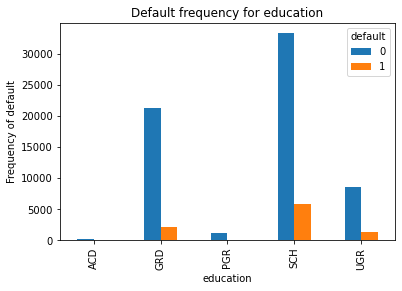

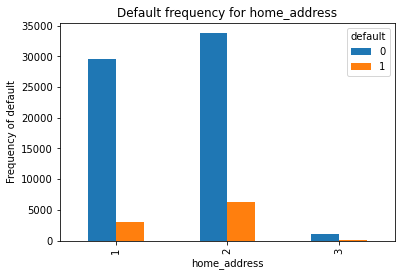

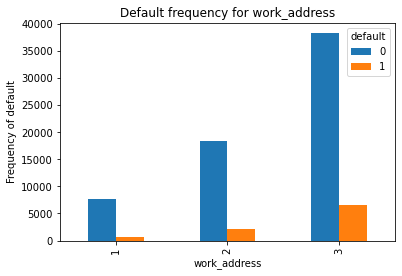

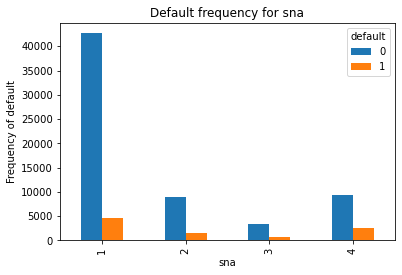

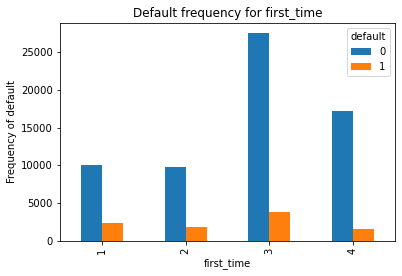

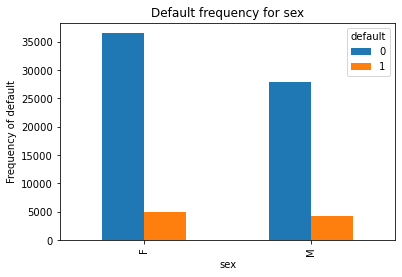

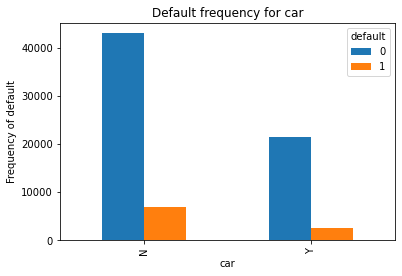

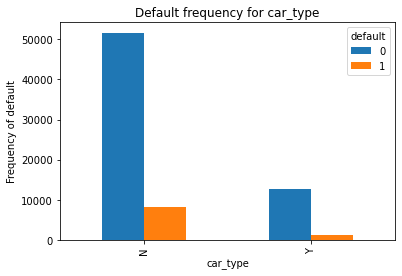

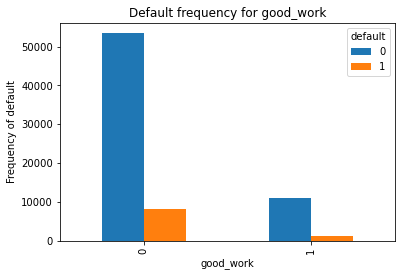

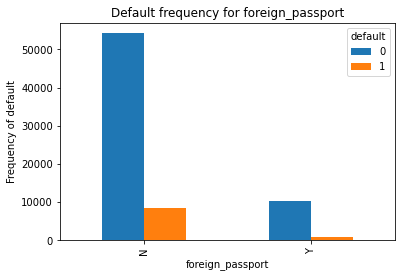

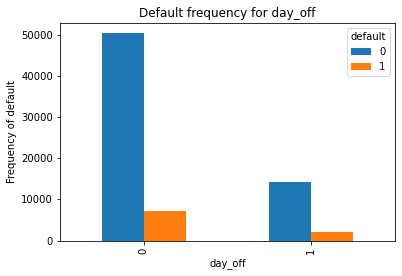

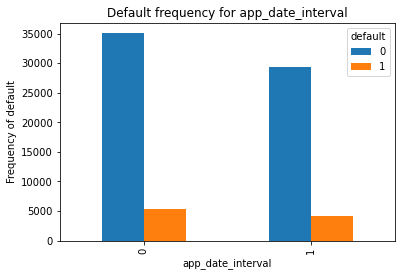

In [205]:
for col in cat_col + bin_col:
    vis_importance(col, 'default')

По визуальному наблюдению все категориальные признаки могут иметь значимость для предсказания дефолта. Разве что признак 'sex' кажется слабым предиктором. Хотя среди женщин ~ на 10к больше нулей дефолта, нужно учитывать, что в датасете женщин в целом примерно ~ на 10к больше, чем мужчин.

### Visual assessment of numerical variables

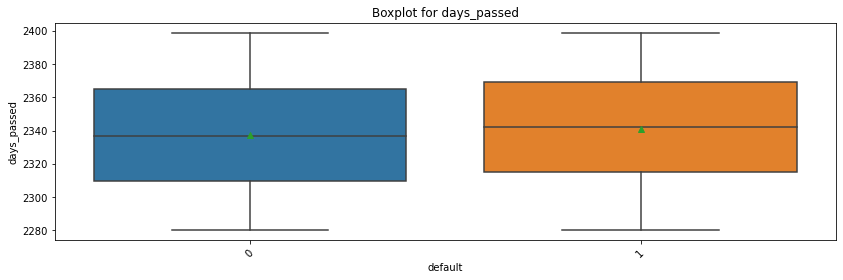

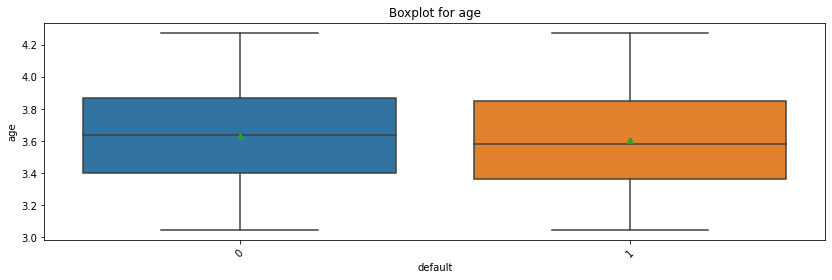

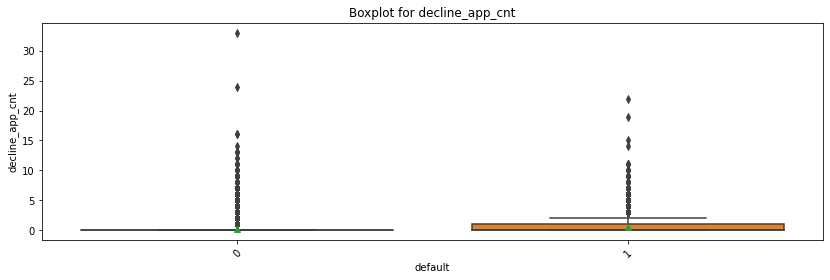

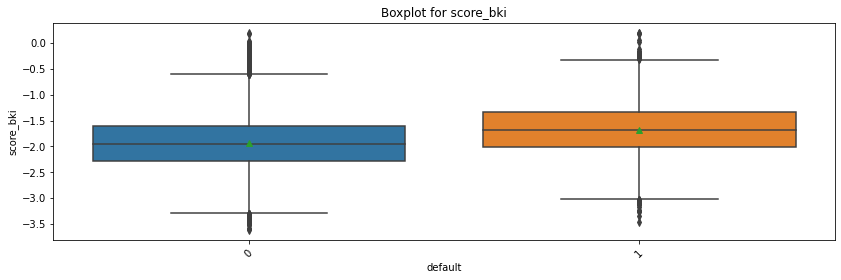

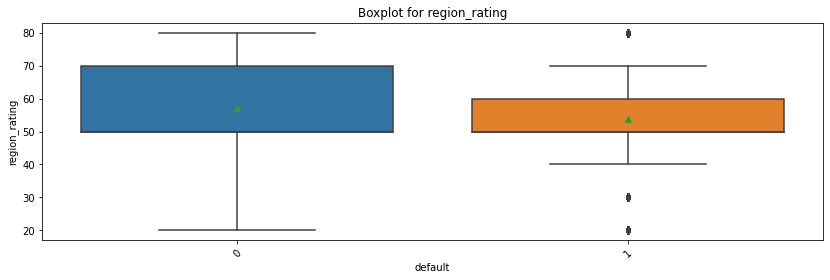

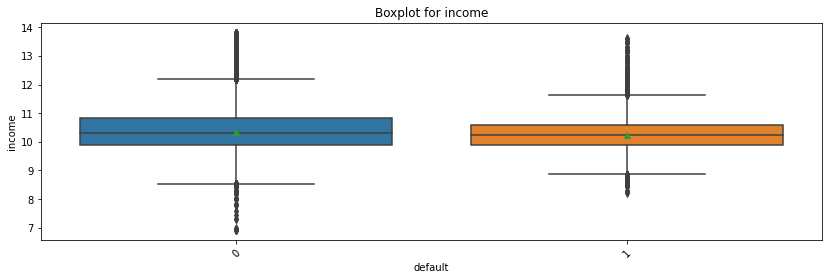

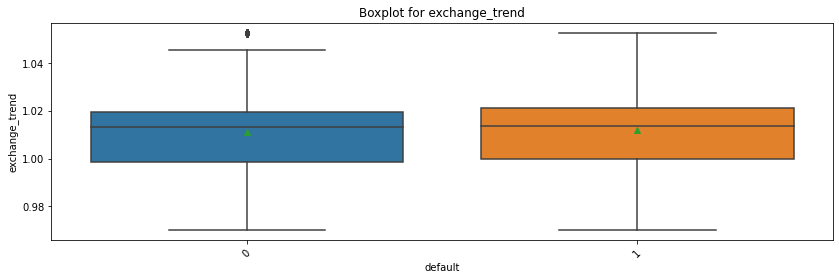

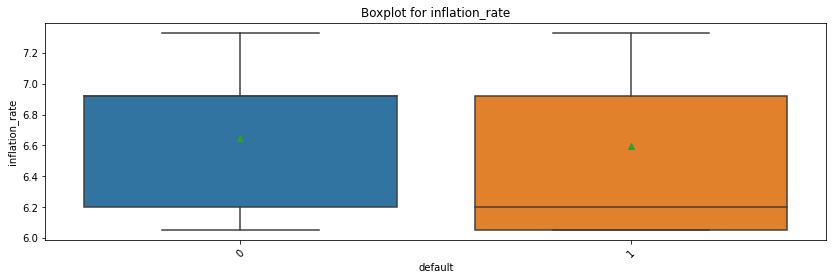

In [206]:
for col in num_col:
    get_boxplot(col)

### Statistical assessment of categorical variables

In [161]:
# encoding categorical cols
for col in ['education', 'sex', 'car', 'car_type', 'foreign_passport', 'day_off', 'app_date_day']:
    encoded_vals, _ = pd.factorize(data[col])
    data[col] = encoded_vals
    
for col in ['education', 'sex', 'car', 'car_type', 'foreign_passport', 'day_off', 'app_date_day']:
    encoded_vals, _ = pd.factorize(test[col])
    test[col] = encoded_vals

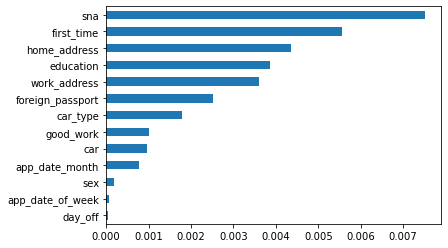

In [162]:
# check importance of categorical variables
imp_cat = pd.Series(mutual_info_classif(data[bin_col + cat_col],
                                        data['default'], discrete_features =True),
                    index = bin_col + cat_col)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Догадка о малой значимости признака 'sex' подтвердилась + теперь видно, что примерно ту же значимость имеет признак 'car' - флаг наличия машины, а также не сильно влияет день недели 'app_day_of_week' и месяц подачи заявки 'app_date_month'.

### Statistical assessment of numerical variables

Text(0.5, 0, 'F-value')

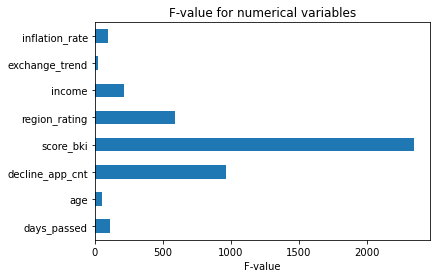

In [163]:
# check importance of numerical variables
imp_num = pd.Series(f_classif(data[num_col],
                              data['default'])[0], index=num_col)
imp_num.plot(kind='barh')
plt.title('F-value for numerical variables')
plt.xlabel('F-value')

Из численных значений самым сильным признаком является оценка кредитного бюро, рейтинг региона (только не ясно, что это за рейтинг и какого региона), отказы

In [103]:
data.shape

(73799, 24)

In [104]:
test.shape

(36349, 23)

# Data Preprocessing

In [164]:
# categorical variables -> dummy-variables
X_cat = sk.preprocessing.OneHotEncoder(sparse=
                        False).fit_transform(data[cat_col].values)

test_cat = sk.preprocessing.OneHotEncoder(sparse=
                        False).fit_transform(test[cat_col].values)

In [165]:
# polynomial feature engeneering
X_num = PolynomialFeatures(2).fit_transform(data[num_col].values)[:,1:]

test_num = PolynomialFeatures(2).fit_transform(test[num_col].values)[:,1:]

In [166]:
X_num = sk.preprocessing.StandardScaler().fit_transform(X_num)

test_num = sk.preprocessing.StandardScaler().fit_transform(test_num)

# Model fitting

In [167]:
X = np.hstack([X_num, X_cat, data[bin_col].values])
y = data['default']

X.shape, y.shape

((73799, 80), (73799,))

In [168]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.20, shuffle=True, random_state=45)

In [169]:
# проверяем еще раз размер выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 80), (14760, 80), (59039,), (14760,))

In [170]:
client_id_test = test.client_id
test = np.hstack([test_num, test_cat, test[bin_col].values])

In [ ]:
C = np.logspace(0, 4, 10)
methods = ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']
hyperparameters = dict(C=C, solver=methods)
model = sk.linear_model.LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

clf = sk.model_selection.GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший Solver:', best_model.best_estimator_.get_params()['solver'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

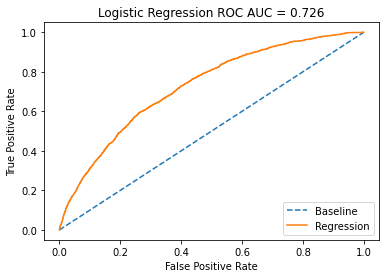

In [171]:
log_reg = sk.linear_model.LogisticRegression(max_iter=500, class_weight='balanced')
model_log_reg = log_reg.fit(X_train, y_train)
y_pred_probs = model_log_reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = sk.metrics.roc_curve(y_test, y_pred_probs)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred_probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [172]:
log_reg = sk.linear_model.LogisticRegression(C=464.16, solver='liblinear', max_iter=500)
model_log_reg = log_reg.fit(X, y)
y_pred_probs = model_log_reg.predict_proba(test)

In [115]:
my_submission = pd.DataFrame({'client_id': client_id_test, 
                              'default': y_pred_probs[:, 1]})
my_submission.to_csv('submission.csv', index=False)

In [ ]:
my_submission.shape